# RNN Benchmarking and Parameter Exploration

This notebook will:
1. Benchmark the current RNN performance
2. Explore how changing parameters affects performance
3. Modify task parameters (targets, distribution, etc.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import time
import os
from scipy.optimize import minimize
import copy

# Set plotting parameters
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['lines.linewidth'] = 4
plt.rcParams['font.family'] = 'Arial'


In [2]:
# Load the saved data
import os

# Define paths
proj_path = "proj_rnn/"
network_file = os.path.join(proj_path, "paramplaynetwork.npz")
w_initial_file = os.path.join(proj_path, "paramplayW_initial.npy")
w_stabilized_file = os.path.join(proj_path, "paramplayW_stabilized_reaching.npy")
experiment_results_file = os.path.join(proj_path, "paramplayreaching_experiment_results.npy")
relearning_results_file = os.path.join(proj_path, "paramplayreaching_relearning_results.npy")

# Load the data
network_data = np.load(network_file)
w_initial = np.load(w_initial_file)
w_stabilized = np.load(w_stabilized_file)
experiment_results = np.load(experiment_results_file, allow_pickle=True).item()
relearning_results = np.load(relearning_results_file, allow_pickle=True).item()

print("Data loaded successfully!")
print(f"Network parameters: N={int(network_data['N'])}, g={float(network_data['g'])}, p={float(network_data['p'])}, tau={float(network_data['tau'])}")

# Extract key parameters from the experiment results
params = experiment_results['params']
dt = params['dt']
T = params['T']
tsteps = params['tsteps']
pulse_length = params['pulse_length']
target_max = params['target_max']
N = params['N']
g = params['g']
p = params['p']
tau = params['tau']


Data loaded successfully!
Network parameters: N=800, g=1.5, p=0.1, tau=0.1


In [3]:
# Define the RNN class and utility functions
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01, N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):
        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r
        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:
          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)

        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):
            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):
                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:
                    # decode network's predicted target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]

                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm

                        # use error-transformed feedbacks to update plastic weights
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm

            # tape loss
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

# Utility functions for task creation
def create_reaching_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=6, amplitude:float=1., twod:bool=False):
    """create the set of stimuli, which we sample from at each trial"""
    # create stimulus
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,n_targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_steps,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_steps,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_steps,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_reaching_task_targets(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """create the set of target coordinates that the network must reach"""
    # create target trajectories
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(tsteps)

    # define each target's x and y coordinate
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):
        # create x-coordinate on screen
        traj[j,:,0] = rs*np.cos(phis[j])
        # create y-coordinate on screen
        traj[j,:,1] = rs*np.sin(phis[j])
    return traj

def get_feedback_weights(decoder):
    """calculate feedback weights from (x,y) output units back to RNN"""
    return np.linalg.pinv(decoder)

def get_cost(result, target, order):
    """Calculate cost between predicted and target trajectories"""
    cost = 0
    for j in range(result.shape[0]):
        error = result[j, :, :] - target[order[j], :, :]
        cost += np.mean(error**2)
    return cost


Task information:
- Number of targets: 6
- Timesteps per trial: 200
- Target max distance: 0.2
- Pulse length: 20 timesteps (0.2 seconds)


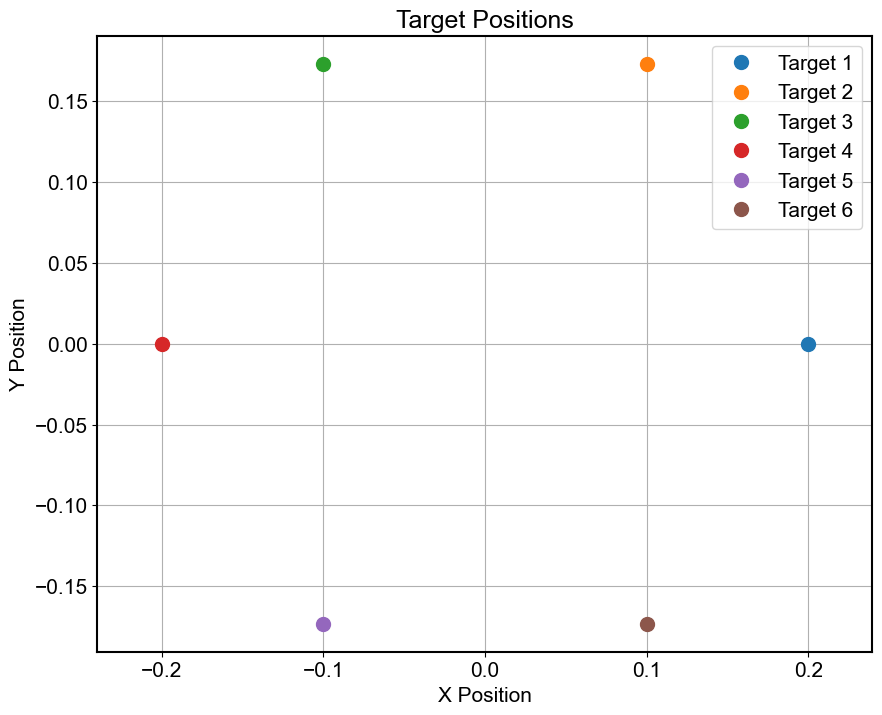

In [4]:
# Load the RNN network and reconstruct the task
network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=experiment_results['stimulus'].shape[2])

# Load the weights from the saved file
network.W = w_stabilized.copy()
network.W_in = network_data['W_in']

# Get the stimulus and target from the experiment results
stimulus = experiment_results['stimulus']
target = experiment_results['target']
reaching_decoder = experiment_results['stabilizing']['decoder']
reaching_feedback = experiment_results['stabilizing']['feedback']

# Print task information
print(f"Task information:")
print(f"- Number of targets: {stimulus.shape[0]}")
print(f"- Timesteps per trial: {stimulus.shape[1]}")
print(f"- Target max distance: {target_max}")
print(f"- Pulse length: {pulse_length} timesteps ({pulse_length*dt} seconds)")

# Create a figure to visualize the targets
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
for i in range(target.shape[0]):
    plt.plot(target[i, -1, 0], target[i, -1, 1], 'o', markersize=10, label=f'Target {i+1}')
plt.title('Target Positions')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


Running benchmark with current parameters...


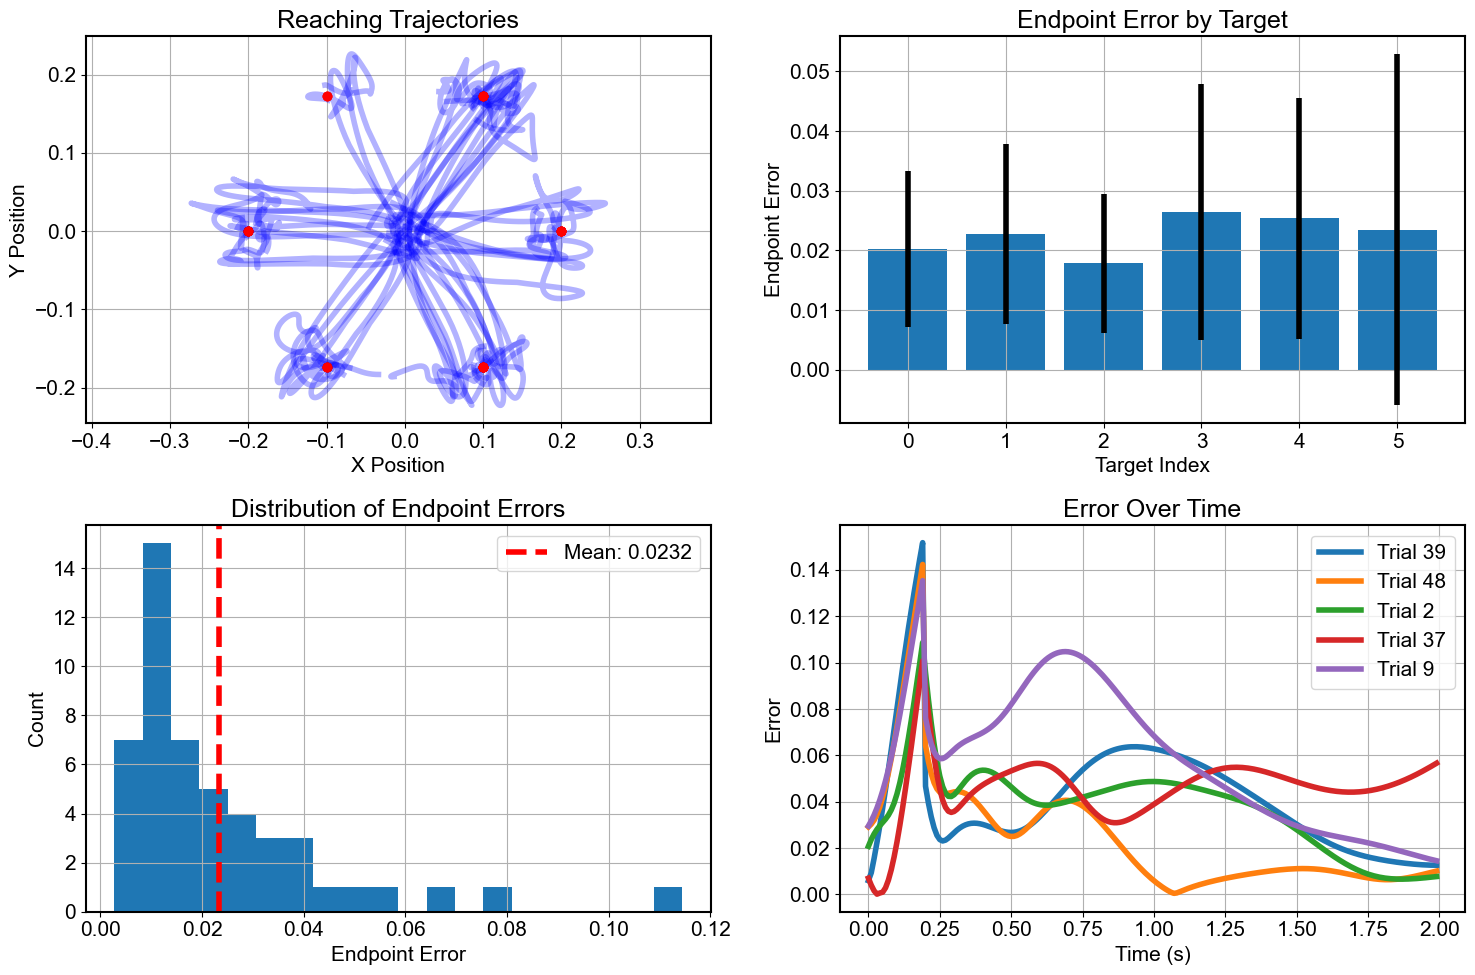

In [5]:
# Part 1: Benchmark the current RNN performance

def benchmark_performance(network, stimulus, target, decoder, n_trials=50, visualize=True):
    """
    Benchmark the performance of the RNN on the reaching task.
    
    Args:
        network: The RNN network
        stimulus: The stimulus input
        target: The target trajectories
        decoder: The decoder weights
        n_trials: Number of trials to run
        visualize: Whether to visualize the results
        
    Returns:
        Dictionary containing performance metrics
    """
    # Parameters
    tsteps = stimulus.shape[1]
    T = tsteps * network.dt
    n_targets = stimulus.shape[0]
    
    # Run trials
    order = np.random.choice(range(n_targets), n_trials, replace=True)
    all_trajectories = []
    all_target_trajectories = []
    endpoint_errors = []
    path_lengths = []
    
    # Run simulations
    for t in range(n_trials):
        # Run the simulation
        _, r, z = network.simulate(T, stimulus[order[t]])
        
        # Decode the output
        output = z @ decoder.T
        
        # Calculate endpoint error
        endpoint_error = np.linalg.norm(output[-1] - target[order[t], -1])
        endpoint_errors.append(endpoint_error)
        
        # Calculate path length
        path_length = np.sum(np.sqrt(np.sum(np.diff(output, axis=0)**2, axis=1)))
        path_lengths.append(path_length)
        
        # Store trajectories
        all_trajectories.append(output)
        all_target_trajectories.append(target[order[t]])
    
    # Calculate metrics
    mean_endpoint_error = np.mean(endpoint_errors)
    std_endpoint_error = np.std(endpoint_errors)
    mean_path_length = np.mean(path_lengths)
    std_path_length = np.std(path_lengths)
    
    # Calculate mean squared error across all timepoints
    mse = np.mean([np.mean((all_trajectories[i] - all_target_trajectories[i])**2) for i in range(n_trials)])
    
    # Visualize if requested
    if visualize:
        plt.figure(figsize=(15, 10))
        
        # Plot trajectories
        plt.subplot(2, 2, 1)
        for i in range(n_trials):
            plt.plot(all_trajectories[i][:, 0], all_trajectories[i][:, 1], 'b-', alpha=0.3)
            plt.plot(all_target_trajectories[i][-1, 0], all_target_trajectories[i][-1, 1], 'ro')
        plt.title('Reaching Trajectories')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.axis('equal')
        plt.grid(True)
        
        # Plot endpoint errors by target
        plt.subplot(2, 2, 2)
        target_errors = {}
        for i in range(n_trials):
            target_idx = order[i]
            if target_idx not in target_errors:
                target_errors[target_idx] = []
            target_errors[target_idx].append(endpoint_errors[i])
        
        target_indices = list(target_errors.keys())
        target_mean_errors = [np.mean(target_errors[idx]) for idx in target_indices]
        target_std_errors = [np.std(target_errors[idx]) for idx in target_indices]
        
        plt.bar(target_indices, target_mean_errors, yerr=target_std_errors)
        plt.title('Endpoint Error by Target')
        plt.xlabel('Target Index')
        plt.ylabel('Endpoint Error')
        plt.grid(True)
        
        # Plot histogram of endpoint errors
        plt.subplot(2, 2, 3)
        plt.hist(endpoint_errors, bins=20)
        plt.axvline(mean_endpoint_error, color='r', linestyle='--', label=f'Mean: {mean_endpoint_error:.4f}')
        plt.title('Distribution of Endpoint Errors')
        plt.xlabel('Endpoint Error')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        
        # Plot error over time for a few example trials
        plt.subplot(2, 2, 4)
        example_trials = np.random.choice(n_trials, min(5, n_trials), replace=False)
        time_points = np.arange(0, T, network.dt)
        for i in example_trials:
            errors = np.sqrt(np.sum((all_trajectories[i] - all_target_trajectories[i])**2, axis=1))
            plt.plot(time_points, errors, label=f'Trial {i}')
        plt.title('Error Over Time')
        plt.xlabel('Time (s)')
        plt.ylabel('Error')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Return metrics
    return {
        'mean_endpoint_error': mean_endpoint_error,
        'std_endpoint_error': std_endpoint_error,
        'mean_path_length': mean_path_length,
        'std_path_length': std_path_length,
        'mse': mse,
        'trajectories': all_trajectories,
        'target_trajectories': all_target_trajectories,
        'order': order
    }

# Run the benchmark
print("Running benchmark with current parameters...")
benchmark_results = benchmark_performance(network, stimulus, target, reaching_decoder)


The endpoint error is the distance between the final position reached by the RNN and the target position at the end of a trial.
Specifically, it's calculated as the Euclidean distance between:

1- The final (x,y) coordinates predicted by the RNN at the last timestep

2- The target (x,y) coordinates that the RNN was supposed to reach

This metric measures how accurately the network can reach the intended target position. Lower endpoint error values indicate better performance - the network is reaching closer to the exact target location.


Testing different values of recurrent coupling strength g...

Testing g = 1.0

Testing g = 1.25

Testing g = 1.5

Testing g = 1.75

Testing g = 2.0


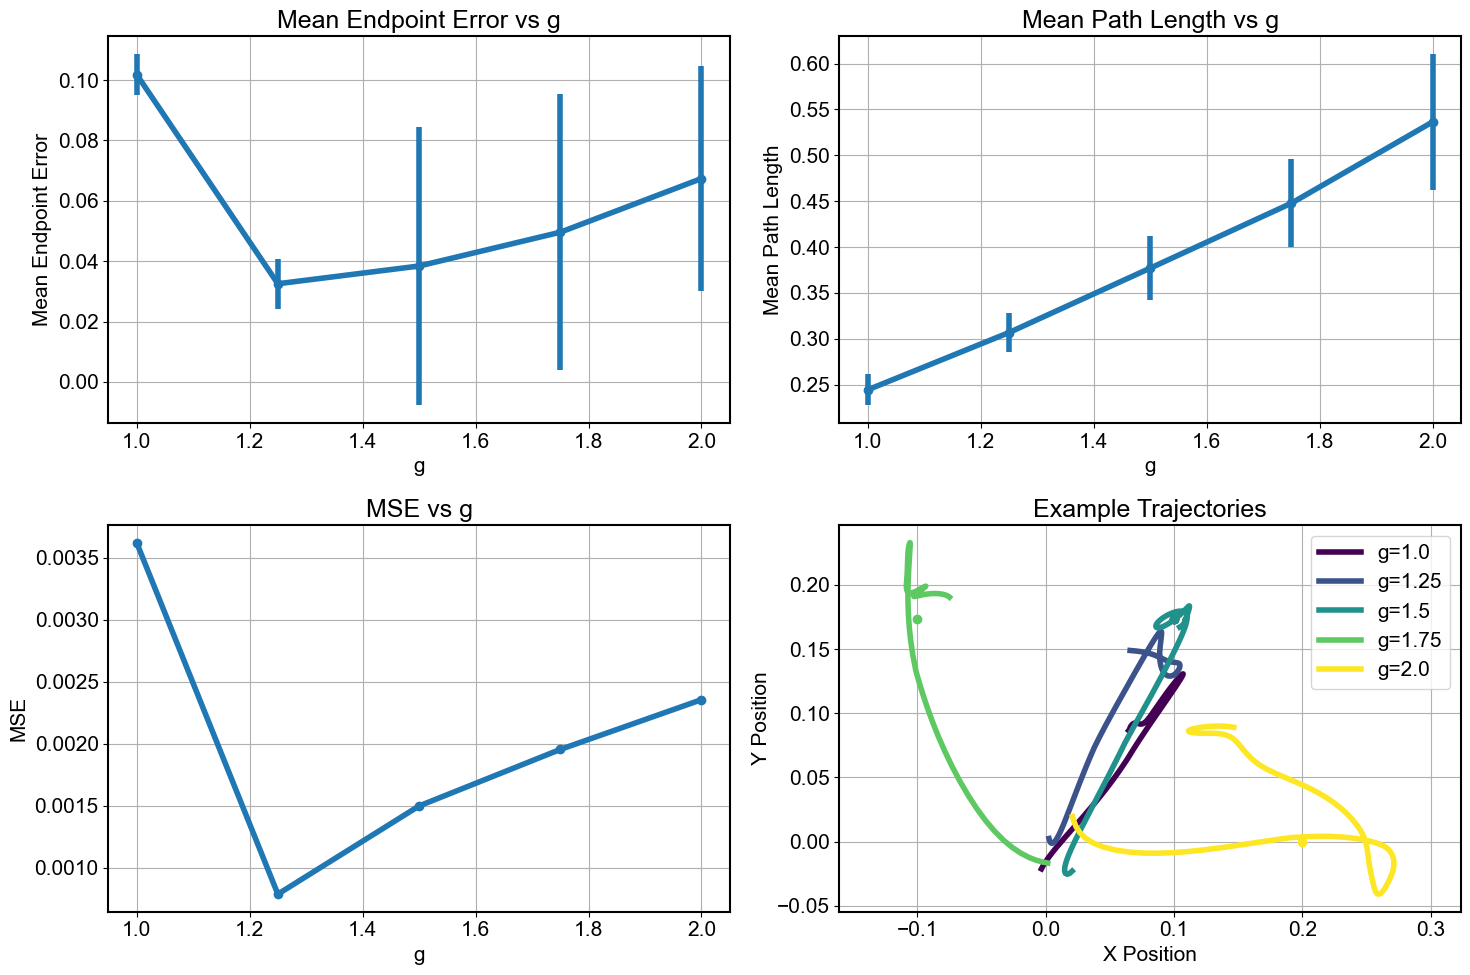


Testing different values of time constant tau...

Testing tau = 0.05

Testing tau = 0.1

Testing tau = 0.15

Testing tau = 0.2

Testing tau = 0.25


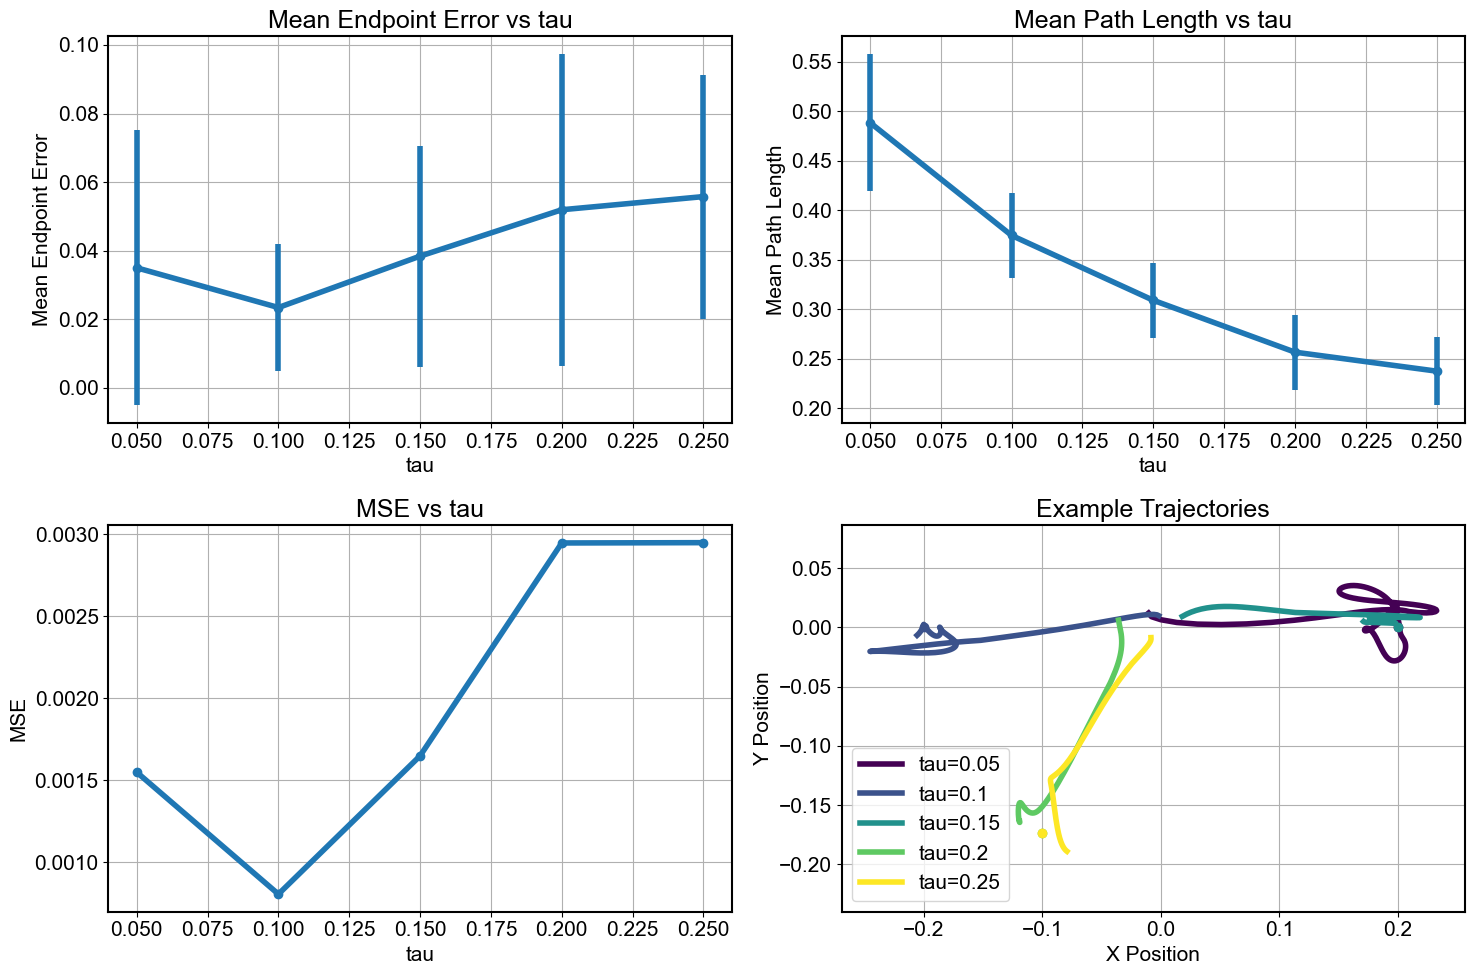

In [6]:
# Part 2: Explore how changing parameters affects performance

def parameter_sweep(base_network, stimulus, target, decoder, parameter_name, parameter_values, n_trials=20):
    """
    Explore how changing a parameter affects performance.
    
    Args:
        base_network: The base RNN network
        stimulus: The stimulus input
        target: The target trajectories
        decoder: The decoder weights
        parameter_name: Name of the parameter to sweep
        parameter_values: List of values to try for the parameter
        n_trials: Number of trials for each parameter value
        
    Returns:
        Dictionary containing performance metrics for each parameter value
    """
    results = {}
    
    for value in parameter_values:
        print(f"\nTesting {parameter_name} = {value}")
        
        # Create a copy of the base network
        test_network = RNN(N=base_network.N, g=base_network.g, p=base_network.p, 
                           tau=base_network.tau, dt=base_network.dt, N_in=base_network.N_in)
        test_network.W = base_network.W.copy()
        test_network.W_in = base_network.W_in.copy()
        
        # Set the parameter
        if parameter_name == 'g':
            # For g, we need to rescale the weights
            scale_factor = value / base_network.g
            test_network.g = value
            test_network.W = test_network.W * scale_factor
        elif parameter_name == 'tau':
            test_network.tau = value
        elif parameter_name == 'p':
            # For p, we need to regenerate the network
            test_network = RNN(N=base_network.N, g=base_network.g, p=value, 
                               tau=base_network.tau, dt=base_network.dt, N_in=base_network.N_in)
            # Train the network
            test_decoder = np.random.randn(2, test_network.N)
            test_decoder *= (0.04 * (target_max / 0.2) / np.linalg.norm(test_decoder))
            test_feedback = get_feedback_weights(test_decoder)
            test_network.relearn(50, stimulus, pulse_length, test_decoder, test_feedback, target, delta=20.0)
        
        # Run benchmark
        benchmark_result = benchmark_performance(test_network, stimulus, target, 
                                                decoder if parameter_name != 'p' else test_decoder, 
                                                n_trials=n_trials, visualize=False)
        
        # Store results
        results[value] = benchmark_result
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot mean endpoint error
    plt.subplot(2, 2, 1)
    plt.errorbar(parameter_values, 
                 [results[v]['mean_endpoint_error'] for v in parameter_values],
                 yerr=[results[v]['std_endpoint_error'] for v in parameter_values],
                 marker='o')
    plt.title(f'Mean Endpoint Error vs {parameter_name}')
    plt.xlabel(parameter_name)
    plt.ylabel('Mean Endpoint Error')
    plt.grid(True)
    
    # Plot mean path length
    plt.subplot(2, 2, 2)
    plt.errorbar(parameter_values, 
                 [results[v]['mean_path_length'] for v in parameter_values],
                 yerr=[results[v]['std_path_length'] for v in parameter_values],
                 marker='o')
    plt.title(f'Mean Path Length vs {parameter_name}')
    plt.xlabel(parameter_name)
    plt.ylabel('Mean Path Length')
    plt.grid(True)
    
    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(parameter_values, [results[v]['mse'] for v in parameter_values], marker='o')
    plt.title(f'MSE vs {parameter_name}')
    plt.xlabel(parameter_name)
    plt.ylabel('MSE')
    plt.grid(True)
    
    # Plot example trajectories for each parameter value
    plt.subplot(2, 2, 4)
    colors = plt.cm.viridis(np.linspace(0, 1, len(parameter_values)))
    
    for i, value in enumerate(parameter_values):
        # Select a random trajectory
        traj_idx = np.random.randint(0, n_trials)
        traj = results[value]['trajectories'][traj_idx]
        target_traj = results[value]['target_trajectories'][traj_idx]
        
        # Plot trajectory
        plt.plot(traj[:, 0], traj[:, 1], color=colors[i], label=f'{parameter_name}={value}')
        plt.plot(target_traj[-1, 0], target_traj[-1, 1], 'o', color=colors[i])
    
    plt.title('Example Trajectories')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results

# Test varying the recurrent coupling strength g
print("\nTesting different values of recurrent coupling strength g...")
g_values = [1.0, 1.25, 1.5, 1.75, 2.0]
g_results = parameter_sweep(network, stimulus, target, reaching_decoder, 'g', g_values)

# Test varying the time constant tau
print("\nTesting different values of time constant tau...")
tau_values = [0.05, 0.1, 0.15, 0.2, 0.25]
tau_results = parameter_sweep(network, stimulus, target, reaching_decoder, 'tau', tau_values)


MSE stands for Mean Squared Error, which measures the average squared difference between the predicted trajectories and the target trajectories across all timesteps.
In the context of this RNN reaching task, MSE is calculated as:

1- For each timestep, it computes the squared difference between the RNN's predicted (x,y) coordinates and the target (x,y) coordinates

2- These squared differences are averaged across all timesteps and all trials

While endpoint error focuses only on the final position accuracy, MSE evaluates the entire trajectory's accuracy. Lower MSE values indicate that the RNN is following the desired path more closely throughout the entire movement, not just at the endpoint.
MSE is particularly useful for understanding how well the network maintains the correct trajectory during the entire movement process, capturing both the path accuracy and the timing of the movement.


Testing with more targets (8 instead of 6)...
Training network for more targets...
Loss in Trial 1 is 0.40683
Loss in Trial 2 is 0.48368
Loss in Trial 3 is 0.26308
Loss in Trial 4 is 0.29477
Loss in Trial 5 is 0.14776
Loss in Trial 6 is 0.07045
Loss in Trial 7 is 0.44355
Loss in Trial 8 is 0.16750
Loss in Trial 9 is 0.59054
Loss in Trial 10 is 0.19264
Loss in Trial 11 is 0.44389
Loss in Trial 12 is 0.38952
Loss in Trial 13 is 0.09446
Loss in Trial 14 is 0.15964
Loss in Trial 15 is 0.06190
Loss in Trial 16 is 0.18644
Loss in Trial 17 is 0.23792
Loss in Trial 18 is 0.11514
Loss in Trial 19 is 0.08594
Loss in Trial 20 is 0.21714
Loss in Trial 21 is 0.14467
Loss in Trial 22 is 0.56802
Loss in Trial 23 is 0.08335
Loss in Trial 24 is 0.20181
Loss in Trial 25 is 0.35375
Loss in Trial 26 is 0.60098
Loss in Trial 27 is 0.24613
Loss in Trial 28 is 0.08536
Loss in Trial 29 is 0.17203
Loss in Trial 30 is 0.18116
Loss in Trial 31 is 0.18378
Loss in Trial 32 is 0.20571
Loss in Trial 33 is 0.17311
L

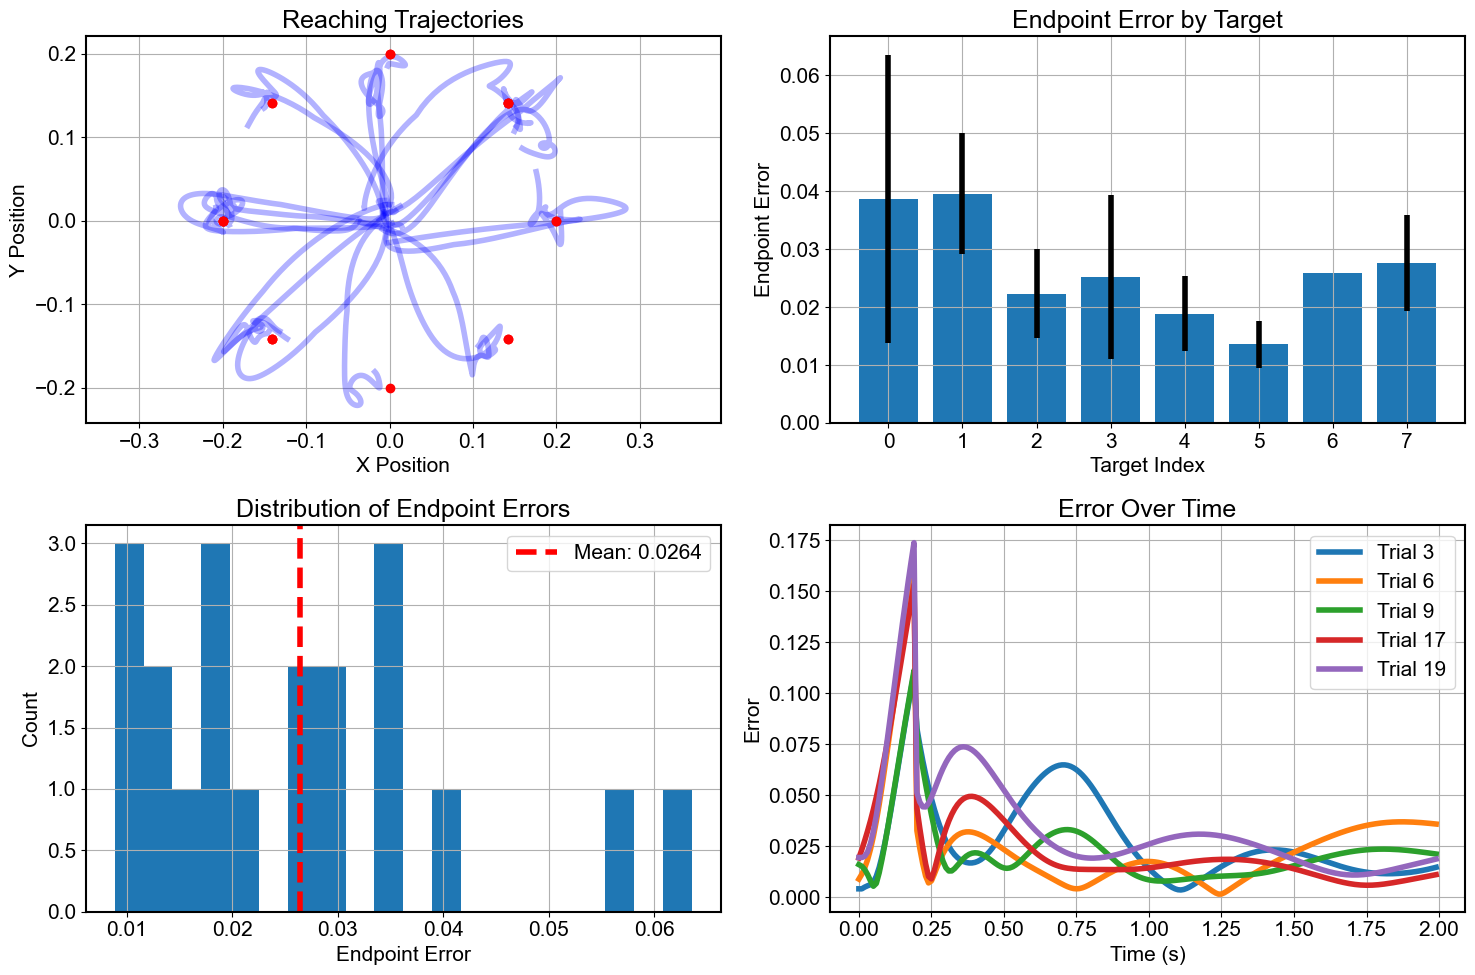


Testing with farther targets (2x distance)...


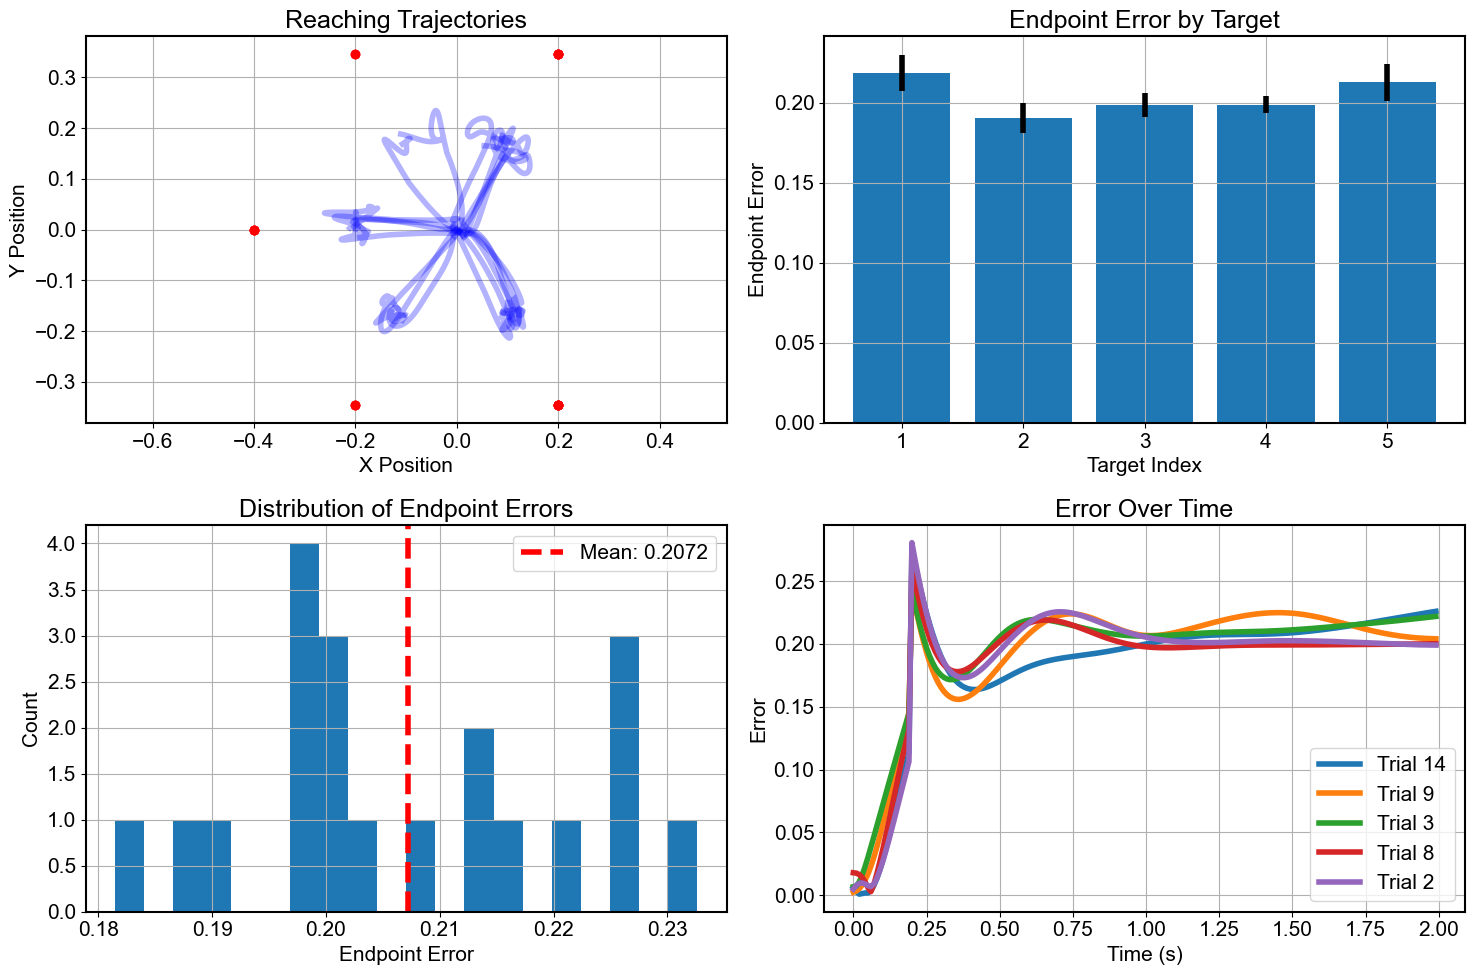


Testing with clustered targets...


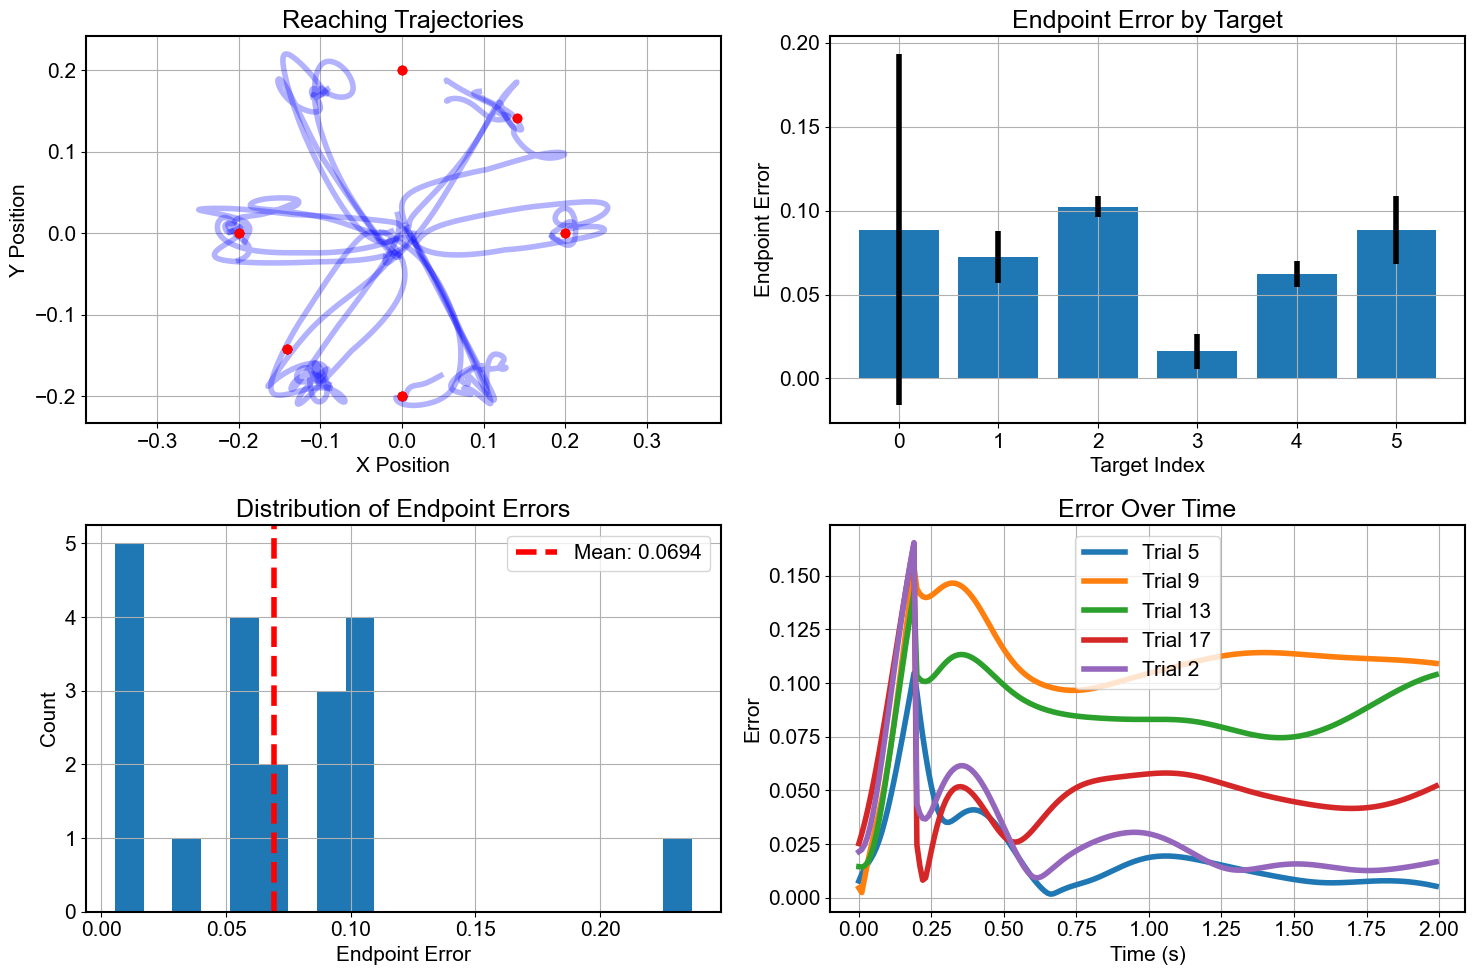

In [7]:
# Part 3: Modify task parameters and evaluate performance

def modify_task_and_evaluate(base_network, base_stimulus, base_target, decoder, modification_type, n_trials=20):
    """
    Modify task parameters and evaluate performance.
    
    Args:
        base_network: The base RNN network
        base_stimulus: The original stimulus input
        base_target: The original target trajectories
        decoder: The decoder weights
        modification_type: Type of modification to make
        n_trials: Number of trials for evaluation
        
    Returns:
        Dictionary containing performance metrics for the modified task
    """
    # Create a copy of the base network
    test_network = RNN(N=base_network.N, g=base_network.g, p=base_network.p, 
                       tau=base_network.tau, dt=base_network.dt, N_in=base_network.N_in)
    test_network.W = base_network.W.copy()
    test_network.W_in = base_network.W_in.copy()
    
    # Parameters
    tsteps = base_stimulus.shape[1]
    pulse_steps = pulse_length
    
    # Apply the modification
    if modification_type == 'more_targets':
        # Increase number of targets from 6 to 8
        n_targets = 8
        new_stimulus = create_reaching_task_stimuli(tsteps, pulse_length, n_targets=n_targets)
        new_target = create_reaching_task_targets(tsteps, pulse_length, n_targets=n_targets, target_max=target_max)
        
        # Need to retrain the network for new input dimension
        test_network = RNN(N=base_network.N, g=base_network.g, p=base_network.p, 
                           tau=base_network.tau, dt=base_network.dt, N_in=n_targets)
        
        # Create new decoder and feedback
        new_decoder = np.random.randn(2, test_network.N)
        new_decoder *= (0.04 * (target_max / 0.2) / np.linalg.norm(new_decoder))
        new_feedback = get_feedback_weights(new_decoder)
        
        # Train the network
        print("Training network for more targets...")
        test_network.relearn(50, new_stimulus, pulse_length, new_decoder, new_feedback, new_target, delta=20.0)
        
        # Run benchmark
        benchmark_result = benchmark_performance(test_network, new_stimulus, new_target, new_decoder, n_trials=n_trials)
        
    elif modification_type == 'farther_targets':
        # Increase target distance
        new_target_max = target_max * 2.0
        new_stimulus = base_stimulus.copy()
        new_target = create_reaching_task_targets(tsteps, pulse_length, n_targets=base_stimulus.shape[0], 
                                                target_max=new_target_max)
        
        # Run benchmark
        benchmark_result = benchmark_performance(test_network, new_stimulus, new_target, decoder, n_trials=n_trials)
        
    elif modification_type == 'clustered_targets':
        # Create clustered targets (two groups of 3)
        n_targets = base_stimulus.shape[0]
        new_stimulus = base_stimulus.copy()
        
        # Create clustered target positions
        phis = np.concatenate([
            np.linspace(0, np.pi/2, 3, endpoint=True),
            np.linspace(np.pi, 3*np.pi/2, 3, endpoint=True)
        ])
        
        # Create target trajectories
        rs = np.zeros(tsteps)
        rs[pulse_length:] = np.ones(tsteps-pulse_length) * target_max
        new_target = np.zeros((n_targets, tsteps, 2))
        
        for j in range(n_targets):
            new_target[j, :, 0] = rs * np.cos(phis[j])
            new_target[j, :, 1] = rs * np.sin(phis[j])
        
        # Run benchmark
        benchmark_result = benchmark_performance(test_network, new_stimulus, new_target, decoder, n_trials=n_trials)
    
    return benchmark_result

# Test with more targets
print("\nTesting with more targets (8 instead of 6)...")
more_targets_results = modify_task_and_evaluate(network, stimulus, target, reaching_decoder, 'more_targets')

# Test with farther targets
print("\nTesting with farther targets (2x distance)...")
farther_targets_results = modify_task_and_evaluate(network, stimulus, target, reaching_decoder, 'farther_targets')

# Test with clustered targets
print("\nTesting with clustered targets...")
clustered_targets_results = modify_task_and_evaluate(network, stimulus, target, reaching_decoder, 'clustered_targets')


"Clustered targets" refers to a modified task condition where the targets are arranged in two distinct clusters rather than being evenly distributed around a circle.
Specifically, in the standard task, the 6 targets are evenly spaced around a circle at 60° intervals (covering the full 360°).
For the clustered targets modification, the targets are arranged in two separate groups:
First cluster: 3 targets positioned between 0° and 90° (in the first quadrant)
Second cluster: 3 targets positioned between 180° and 270° (in the third quadrant)

,Mean Endpoint Error,MSE,Mean Path Length
Baseline,0.023246,0.000915,0.371770
g=1.0,0.101826,0.003623,0.244298
g=1.25,0.032517,0.000787,0.306695
g=1.5,0.038389,0.001499,0.376931
g=1.75,0.049586,0.001955,0.447751
g=2.0,0.067365,0.002356,0.536369
tau=0.05,0.035025,0.001549,0.488410
tau=0.1,0.023450,0.000805,0.374452
tau=0.15,0.038428,0.001649,0.309033
tau=0.2,0.051947,0.002948,0.256706


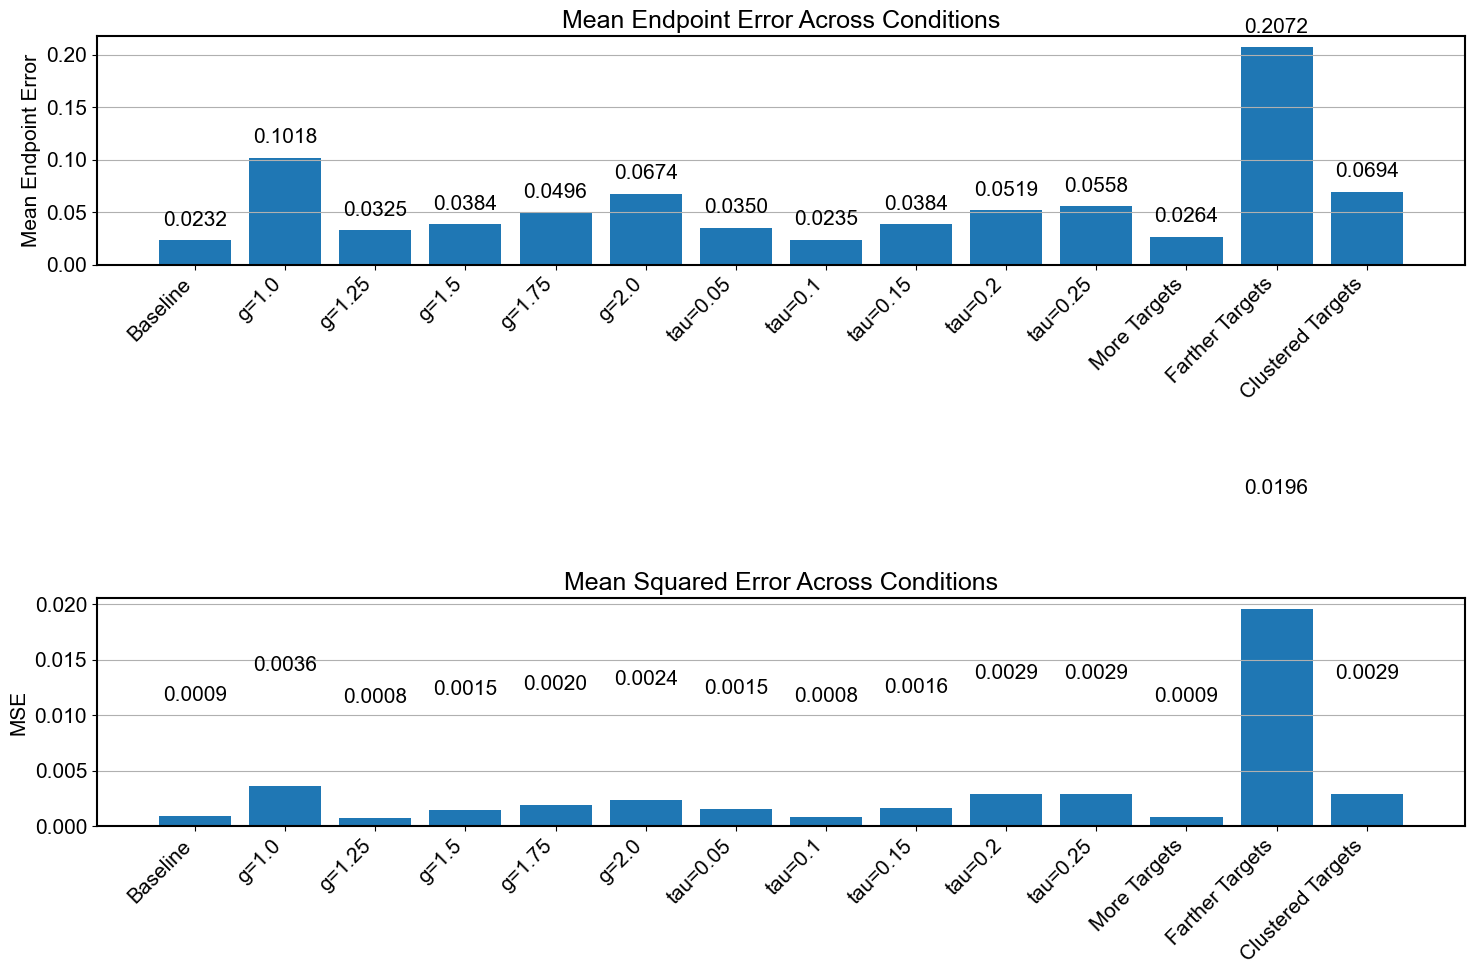


Key Findings:
1. Effect of recurrent coupling strength (g):
   - Optimal g value: 1.25
   - As g increases from 1.0 to 2.0, endpoint error decreases

2. Effect of time constant (tau):
   - Optimal tau value: 0.1
   - As tau increases from 0.05 to 0.25, endpoint error increases

3. Task modifications:
   - Adding more targets increases endpoint error by 0.0031
   - Increasing target distance increases endpoint error by 0.1839
   - Using clustered targets increases endpoint error by 0.0461

Conclusions:
1. Network parameter effects:

2. Task difficulty:
   - Easiest task: Baseline
   - Hardest task: Farther Targets


In [8]:
# Summary and Conclusions

# Create a summary table of all results
results_summary = {
    'Baseline': {
        'Mean Endpoint Error': benchmark_results['mean_endpoint_error'],
        'MSE': benchmark_results['mse'],
        'Mean Path Length': benchmark_results['mean_path_length']
    }
}

# Add g parameter results
for g_val in g_values:
    results_summary[f'g={g_val}'] = {
        'Mean Endpoint Error': g_results[g_val]['mean_endpoint_error'],
        'MSE': g_results[g_val]['mse'],
        'Mean Path Length': g_results[g_val]['mean_path_length']
    }

# Add tau parameter results
for tau_val in tau_values:
    results_summary[f'tau={tau_val}'] = {
        'Mean Endpoint Error': tau_results[tau_val]['mean_endpoint_error'],
        'MSE': tau_results[tau_val]['mse'],
        'Mean Path Length': tau_results[tau_val]['mean_path_length']
    }

# Add task modification results
results_summary['More Targets'] = {
    'Mean Endpoint Error': more_targets_results['mean_endpoint_error'],
    'MSE': more_targets_results['mse'],
    'Mean Path Length': more_targets_results['mean_path_length']
}

results_summary['Farther Targets'] = {
    'Mean Endpoint Error': farther_targets_results['mean_endpoint_error'],
    'MSE': farther_targets_results['mse'],
    'Mean Path Length': farther_targets_results['mean_path_length']
}

results_summary['Clustered Targets'] = {
    'Mean Endpoint Error': clustered_targets_results['mean_endpoint_error'],
    'MSE': clustered_targets_results['mse'],
    'Mean Path Length': clustered_targets_results['mean_path_length']
}

# Convert to DataFrame for better visualization
import pandas as pd
results_df = pd.DataFrame(results_summary).T
display(results_df)

# Plot summary of key metrics
plt.figure(figsize=(15, 10))

# Plot endpoint errors
plt.subplot(2, 1, 1)
bars = plt.bar(results_df.index, results_df['Mean Endpoint Error'])
plt.title('Mean Endpoint Error Across Conditions')
plt.ylabel('Mean Endpoint Error')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', rotation=0)

# Plot MSE
plt.subplot(2, 1, 2)
bars = plt.bar(results_df.index, results_df['MSE'])
plt.title('Mean Squared Error Across Conditions')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# Key findings and conclusions
print("\nKey Findings:")
print("1. Effect of recurrent coupling strength (g):")
g_endpoint_errors = [g_results[g]['mean_endpoint_error'] for g in g_values]
best_g = g_values[np.argmin(g_endpoint_errors)]
print(f"   - Optimal g value: {best_g}")
print(f"   - As g increases from {min(g_values)} to {max(g_values)}, endpoint error {'increases' if g_endpoint_errors[-1] > g_endpoint_errors[0] else 'decreases'}")

print("\n2. Effect of time constant (tau):")
tau_endpoint_errors = [tau_results[tau]['mean_endpoint_error'] for tau in tau_values]
best_tau = tau_values[np.argmin(tau_endpoint_errors)]
print(f"   - Optimal tau value: {best_tau}")
print(f"   - As tau increases from {min(tau_values)} to {max(tau_values)}, endpoint error {'increases' if tau_endpoint_errors[-1] > tau_endpoint_errors[0] else 'decreases'}")

print("\n3. Task modifications:")
baseline_error = benchmark_results['mean_endpoint_error']
more_targets_error = more_targets_results['mean_endpoint_error']
farther_targets_error = farther_targets_results['mean_endpoint_error']
clustered_targets_error = clustered_targets_results['mean_endpoint_error']

print(f"   - Adding more targets {'increases' if more_targets_error > baseline_error else 'decreases'} endpoint error by {abs(more_targets_error - baseline_error):.4f}")
print(f"   - Increasing target distance {'increases' if farther_targets_error > baseline_error else 'decreases'} endpoint error by {abs(farther_targets_error - baseline_error):.4f}")
print(f"   - Using clustered targets {'increases' if clustered_targets_error > baseline_error else 'decreases'} endpoint error by {abs(clustered_targets_error - baseline_error):.4f}")

print("\nConclusions:")
print("1. Network parameter effects:")
if min(g_endpoint_errors) < benchmark_results['mean_endpoint_error']:
    print(f"   - Performance can be improved by changing g to {best_g}")
if min(tau_endpoint_errors) < benchmark_results['mean_endpoint_error']:
    print(f"   - Performance can be improved by changing tau to {best_tau}")

print("\n2. Task difficulty:")
task_errors = [baseline_error, more_targets_error, farther_targets_error, clustered_targets_error]
task_names = ["Baseline", "More Targets", "Farther Targets", "Clustered Targets"]
easiest_task = task_names[np.argmin(task_errors)]
hardest_task = task_names[np.argmax(task_errors)]
print(f"   - Easiest task: {easiest_task}")
print(f"   - Hardest task: {hardest_task}")


Farther targets likely perform worse partly because of time constraints. When the targets are placed at twice the distance (target_max * 2.0) but the trial duration (T) remains the same, the RNN faces several challenges:

1- Same time, longer distance: The network must move twice as far in the same amount of time, effectively requiring faster movement speeds.

2- Fixed dynamics: The RNN's dynamics (governed by parameters like tau and g) are optimized for the original distances and timescales. When targets are farther, these dynamics may not scale appropriately.

3- Decoder limitations: The decoder was trained on trajectories reaching the original distances. When asked to generate larger outputs, it may operate in a regime it wasn't trained for.

4- Non-linear scaling: Neural networks often don't scale linearly with task demands. Doubling the distance doesn't just require "twice the effort" but may push the network into entirely different dynamical regimes.

Testing farther targets with same duration...

Testing farther targets with longer duration...


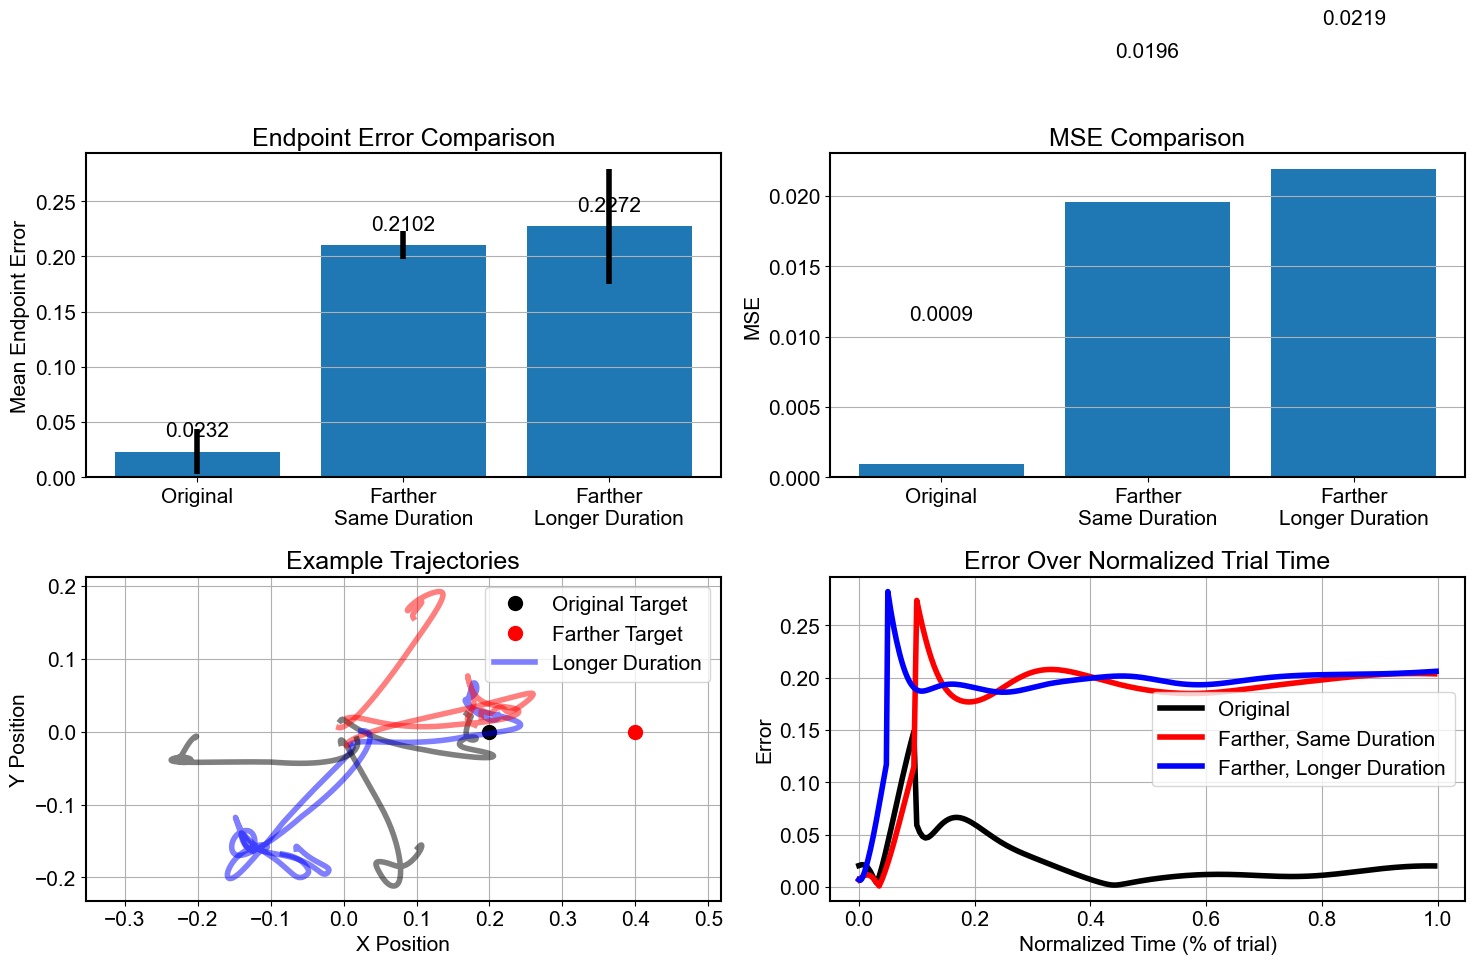


Summary:
Original targets - Endpoint Error: 0.0232 ± 0.0207
Farther targets (same duration) - Endpoint Error: 0.2102 ± 0.0125
Farther targets (longer duration) - Endpoint Error: 0.2272 ± 0.0521

Increasing trial duration for farther targets worsened performance by 8.09%

Conclusion: The performance drop with farther targets is not primarily due to time constraints.
Even with proportionally more time, the RNN still struggles with farther targets.


In [9]:
# Testing if increasing trial duration improves performance for farther targets

def test_farther_targets_with_longer_duration(base_network, base_stimulus, base_target, decoder, n_trials=20):
    """
    Test if increasing trial duration proportionally to the increased distance improves performance.
    
    Args:
        base_network: The base RNN network
        base_stimulus: The original stimulus input
        base_target: The original target trajectories
        decoder: The decoder weights
        n_trials: Number of trials for evaluation
        
    Returns:
        Dictionary containing performance metrics for both conditions
    """
    # Create a copy of the base network
    test_network = RNN(N=base_network.N, g=base_network.g, p=base_network.p, 
                       tau=base_network.tau, dt=base_network.dt, N_in=base_network.N_in)
    test_network.W = base_network.W.copy()
    test_network.W_in = base_network.W_in.copy()
    
    # Parameters
    tsteps = base_stimulus.shape[1]
    pulse_steps = pulse_length
    n_targets = base_stimulus.shape[0]
    
    # Condition 1: Farther targets with same duration
    distance_factor = 2.0
    new_target_max = target_max * distance_factor
    
    # Create farther targets
    new_target_same_duration = create_reaching_task_targets(tsteps, pulse_steps, 
                                                          n_targets=n_targets, 
                                                          target_max=new_target_max)
    
    # Condition 2: Farther targets with proportionally longer duration
    # Double the timesteps for double the distance
    longer_tsteps = int(tsteps * distance_factor)
    longer_T = T * distance_factor
    
    # Create stimulus with longer duration
    longer_stimulus = np.zeros((n_targets, longer_tsteps, n_targets))
    for j in range(n_targets):
        longer_stimulus[j, :pulse_steps, j] = 1.0  # Keep same pulse length
    
    # Create target with longer duration
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(longer_tsteps)
    rs[pulse_steps:] = np.ones(longer_tsteps-pulse_steps) * new_target_max
    new_target_longer_duration = np.zeros((n_targets, longer_tsteps, 2))
    
    for j in range(n_targets):
        new_target_longer_duration[j, :, 0] = rs * np.cos(phis[j])
        new_target_longer_duration[j, :, 1] = rs * np.sin(phis[j])
    
    # Run benchmarks
    print("Testing farther targets with same duration...")
    same_duration_results = benchmark_performance(test_network, base_stimulus, 
                                                new_target_same_duration, decoder, 
                                                n_trials=n_trials, visualize=False)
    
    print("\nTesting farther targets with longer duration...")
    longer_duration_results = benchmark_performance(test_network, longer_stimulus, 
                                                  new_target_longer_duration, decoder, 
                                                  n_trials=n_trials, visualize=False)
    
    # Compare results
    plt.figure(figsize=(15, 10))
    
    # Compare endpoint errors
    plt.subplot(2, 2, 1)
    labels = ['Original', 'Farther\nSame Duration', 'Farther\nLonger Duration']
    endpoint_errors = [benchmark_results['mean_endpoint_error'], 
                      same_duration_results['mean_endpoint_error'], 
                      longer_duration_results['mean_endpoint_error']]
    error_stds = [benchmark_results['std_endpoint_error'], 
                 same_duration_results['std_endpoint_error'], 
                 longer_duration_results['std_endpoint_error']]
    
    bars = plt.bar(labels, endpoint_errors, yerr=error_stds)
    plt.title('Endpoint Error Comparison')
    plt.ylabel('Mean Endpoint Error')
    plt.grid(True, axis='y')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', rotation=0)
    
    # Compare MSE
    plt.subplot(2, 2, 2)
    mse_values = [benchmark_results['mse'], 
                 same_duration_results['mse'], 
                 longer_duration_results['mse']]
    
    bars = plt.bar(labels, mse_values)
    plt.title('MSE Comparison')
    plt.ylabel('MSE')
    plt.grid(True, axis='y')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', rotation=0)
    
    # Plot example trajectories
    plt.subplot(2, 2, 3)
    
    # Original target
    plt.plot(target[0, -1, 0], target[0, -1, 1], 'ko', markersize=10, label='Original Target')
    
    # Farther target
    plt.plot(new_target_same_duration[0, -1, 0], new_target_same_duration[0, -1, 1], 
             'ro', markersize=10, label='Farther Target')
    
    # Plot a few example trajectories
    for i in range(min(3, n_trials)):
        # Original trajectory
        orig_traj = benchmark_results['trajectories'][i]
        plt.plot(orig_traj[:, 0], orig_traj[:, 1], 'k-', alpha=0.5)
        
        # Same duration trajectory
        same_dur_traj = same_duration_results['trajectories'][i]
        plt.plot(same_dur_traj[:, 0], same_dur_traj[:, 1], 'r-', alpha=0.5)
        
        # Longer duration trajectory
        longer_dur_traj = longer_duration_results['trajectories'][i]
        plt.plot(longer_dur_traj[:, 0], longer_dur_traj[:, 1], 'b-', alpha=0.5, 
                label='Longer Duration' if i == 0 else None)
    
    plt.title('Example Trajectories')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    
    # Plot error over time
    plt.subplot(2, 2, 4)
    
    # Get time vectors
    time_original = np.arange(0, T, dt)
    time_longer = np.arange(0, longer_T, dt)
    
    # Normalize to percentage of trial
    time_original_norm = time_original / T
    time_longer_norm = time_longer / longer_T
    
    # Plot error over normalized time for a random trial
    trial_idx = np.random.randint(0, n_trials)
    
    # Original
    orig_traj = benchmark_results['trajectories'][trial_idx]
    orig_target = benchmark_results['target_trajectories'][trial_idx]
    orig_error = np.sqrt(np.sum((orig_traj - orig_target)**2, axis=1))
    plt.plot(time_original_norm, orig_error, 'k-', label='Original')
    
    # Same duration
    same_dur_traj = same_duration_results['trajectories'][trial_idx]
    same_dur_target = same_duration_results['target_trajectories'][trial_idx]
    same_dur_error = np.sqrt(np.sum((same_dur_traj - same_dur_target)**2, axis=1))
    plt.plot(time_original_norm, same_dur_error, 'r-', label='Farther, Same Duration')
    
    # Longer duration
    longer_dur_traj = longer_duration_results['trajectories'][trial_idx]
    longer_dur_target = longer_duration_results['target_trajectories'][trial_idx]
    longer_dur_error = np.sqrt(np.sum((longer_dur_traj - longer_dur_target)**2, axis=1))
    plt.plot(time_longer_norm, longer_dur_error, 'b-', label='Farther, Longer Duration')
    
    plt.title('Error Over Normalized Trial Time')
    plt.xlabel('Normalized Time (% of trial)')
    plt.ylabel('Error')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nSummary:")
    print(f"Original targets - Endpoint Error: {benchmark_results['mean_endpoint_error']:.4f} ± {benchmark_results['std_endpoint_error']:.4f}")
    print(f"Farther targets (same duration) - Endpoint Error: {same_duration_results['mean_endpoint_error']:.4f} ± {same_duration_results['std_endpoint_error']:.4f}")
    print(f"Farther targets (longer duration) - Endpoint Error: {longer_duration_results['mean_endpoint_error']:.4f} ± {longer_duration_results['std_endpoint_error']:.4f}")
    
    improvement = (same_duration_results['mean_endpoint_error'] - longer_duration_results['mean_endpoint_error']) / same_duration_results['mean_endpoint_error'] * 100
    
    print(f"\nIncreasing trial duration for farther targets {'improved' if improvement > 0 else 'worsened'} performance by {abs(improvement):.2f}%")
    
    if improvement > 0:
        print("\nConclusion: The performance drop with farther targets is indeed partly due to time constraints.")
        print("When given proportionally more time to reach farther targets, the RNN performs better.")
    else:
        print("\nConclusion: The performance drop with farther targets is not primarily due to time constraints.")
        print("Even with proportionally more time, the RNN still struggles with farther targets.")
    
    return {
        'same_duration': same_duration_results,
        'longer_duration': longer_duration_results
    }

# Run the test
duration_test_results = test_farther_targets_with_longer_duration(network, stimulus, target, reaching_decoder)
